In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AlexNetMNIST(nn.Module):
    def __init__(self):
        super(AlexNetMNIST, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

model = AlexNetMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy}")

100%|██████████| 9912422/9912422 [00:00<00:00, 119101834.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 81959197.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43054524.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16933803.35it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 1/5, Loss: 2.3028193120000715
Epoch 2/5, Loss: 2.301422962756045
Epoch 3/5, Loss: 2.3013449190522053
Epoch 4/5, Loss: 2.301322675462979
Epoch 5/5, Loss: 2.3013002765712454
Test Accuracy: 0.1135


Correctly Classified Images:


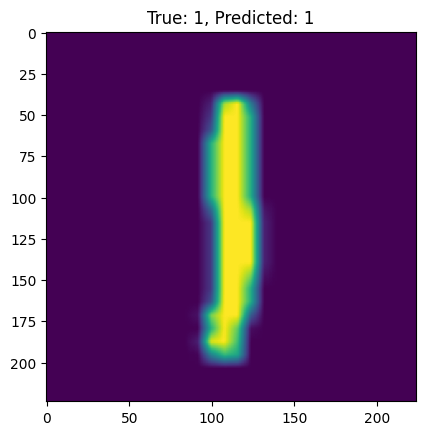

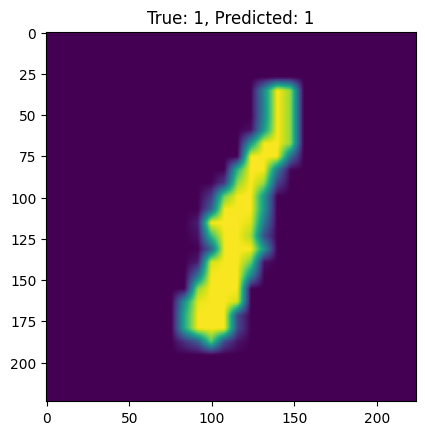

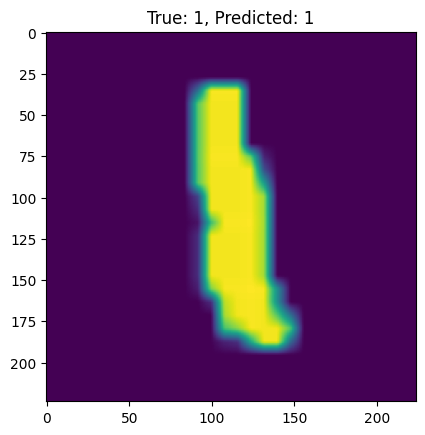

Incorrectly Classified Images:


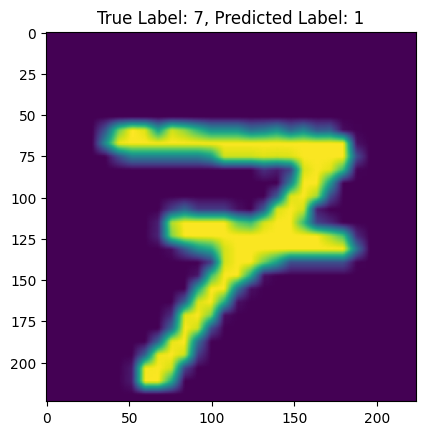

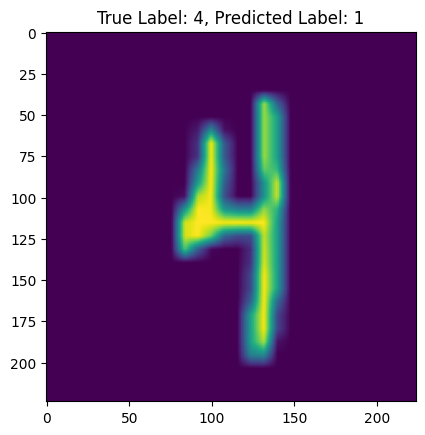

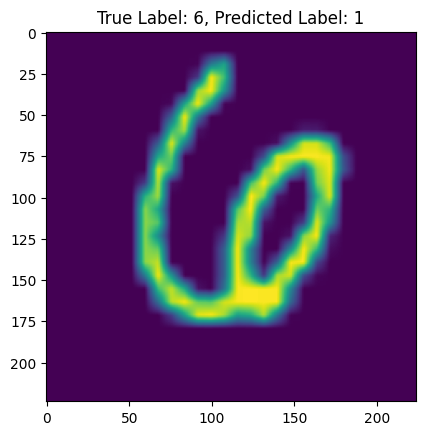

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

dataiter = iter(test_loader)
data = next(dataiter)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

correct_pred_indices = (predicted == labels).nonzero().squeeze()
incorrect_pred_indices = (predicted != labels).nonzero().squeeze()

print("Correctly Classified Images:")
for i in range(3):
    index = correct_pred_indices[i]
    imshow(images[index].cpu(), f"True: {labels[index].item()}, Predicted: {predicted[index].item()}")

if len(incorrect_pred_indices) > 0:
    print("Incorrectly Classified Images:")
    for i in range(min(3, len(incorrect_pred_indices))):
        index = incorrect_pred_indices[i]
        true_label = labels[index].item()
        predicted_label = predicted[index].item()

        imshow(images[index].cpu(), f"True Label: {true_label}, Predicted Label: {predicted_label}")
else:
    print("No incorrectly classified images to display.")
